<i>1995-07-09 23:00:00 Versailles, Mo - "USAF officer relays report re: 5 bizarre ships seen hovering over field"</i>

<i>1962-11-15 21:00:00 Runge,Tx - "creature in transparent sphere panics at being seen by nine year old boy"</i>

<i>1996-02-10 11:00:00 Alice Springs, Australia - "a humanoid dwarf/troll/grey alien type thing walked up the steps of a pasta restataunt I was in and stared at me"</i>


#### The Data
The dataset at the focus of this project is a collection of over 80,000 reported UFO sightings from the last 100 years. Each record has the date, time, location, duration, a comment describing the event, and some other information. More information and download links for the dataset can be found <a href='https://github.com/planetsig/ufo-reports'>here</a>

In this notebook I've done visualization and analysis of some features of the dataset. I've also integrated US state population data with with my findings to create a choropleth map of the (contiguous) United States, showing which states have the most reported UFO sightings per capita.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import (desc,
                                   to_timestamp,
                                   year,
                                   month,
                                   hour)
from pyspark.sql.types import (StructField,
                               StringType,
                               IntegerType,
                               StructType,
                               DateType,
                               DoubleType)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from bokeh.io import show, output_notebook
from bokeh.plotting import figure

# state data for drawing choropleth map
from bokeh.sampledata.us_states import data as states

In [2]:
# create spark spession
# although this data is small enough to use pandas, I'll use spark for the practice
spark = SparkSession.builder.appName('UFO').getOrCreate()

In [3]:
# notebook settings
%matplotlib inline
sns.set_style("darkgrid")

In [4]:
# read the csv with spark and view the data's schema
ufos = spark.read.csv('scrubbed.csv', inferSchema=True, header=True)
ufos.printSchema()
#ufos.show(5)

root
 |-- datetime: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- country: string (nullable = true)
 |-- shape: string (nullable = true)
 |-- duration (seconds): string (nullable = true)
 |-- duration (hours/min): string (nullable = true)
 |-- comments: string (nullable = true)
 |-- date posted: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude : double (nullable = true)



#### To be able to process the data correctly, some columns need to be cast to different types.

In [5]:
ufos = (ufos
            .withColumn("duration (seconds)", ufos["duration (seconds)"].cast(IntegerType()))
            .withColumn("latitude", ufos["latitude"].cast(DoubleType()))
            .withColumn("datetime", to_timestamp(ufos['datetime'], "M/d/y H:m"))   
       )

ufos.printSchema()
ufos.show(5)

root
 |-- datetime: timestamp (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- country: string (nullable = true)
 |-- shape: string (nullable = true)
 |-- duration (seconds): integer (nullable = true)
 |-- duration (hours/min): string (nullable = true)
 |-- comments: string (nullable = true)
 |-- date posted: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude : double (nullable = true)

+-------------------+--------------------+-----+-------+--------+------------------+--------------------+--------------------+-----------+----------+------------+
|           datetime|                city|state|country|   shape|duration (seconds)|duration (hours/min)|            comments|date posted|  latitude|  longitude |
+-------------------+--------------------+-----+-------+--------+------------------+--------------------+--------------------+-----------+----------+------------+
|1949-10-10 20:30:00|          san marcos|   

In [6]:
# a summary of the data
ufos.describe().show()

+-------+--------------------+-----+-------+-------+------------------+--------------------+--------------------+-----------+------------------+------------------+
|summary|                city|state|country|  shape|duration (seconds)|duration (hours/min)|            comments|date posted|          latitude|        longitude |
+-------+--------------------+-----+-------+-------+------------------+--------------------+--------------------+-----------+------------------+------------------+
|  count|               80332|74535|  70662|  78400|             80328|               80332|               80317|      80332|             80331|             80332|
|   mean|                null| null|   null|   null| 8984.575839059855|  2.6849339622641506|                 5.0|       null|  38.1244768246188|-86.77288454711717|
| stddev|                null| null|   null|   null| 620163.1992988552|   5.291727709756899|  2.8284271247461903|       null|10.469636244288958| 39.69720464576765|
|    min|&ccedil

### Exploring the Unkown: Visualizing the Data
To get a feel for the dataset as a whole, we'll use the spark dataframe .toPandas() method to pull smaller parts of the data into pandas to make use of the nicer dataframe display and convenient seaborn plotting. 

First we'll look at the frequency distribution of the shape column.

In [7]:
# show the top 5 most frequent ufo shapes reported
def count_values(df, column):
    """Count the occurences of each unique value in a column, sort by descending counts"""
    col_freq = (df
        .groupby(column)
        .count()
        .sort(desc('count')))
    return col_freq

# show value counts for the shape column
shape_freq = count_values(ufos, 'shape').toPandas()
shape_freq.head(5)

,shape,count
0,light,16565
1,triangle,7865
2,circle,7608
3,fireball,6208
4,other,5649


[Text(0,0.5,'Shape'), Text(0.5,0,'Reported UFO Sightings')]

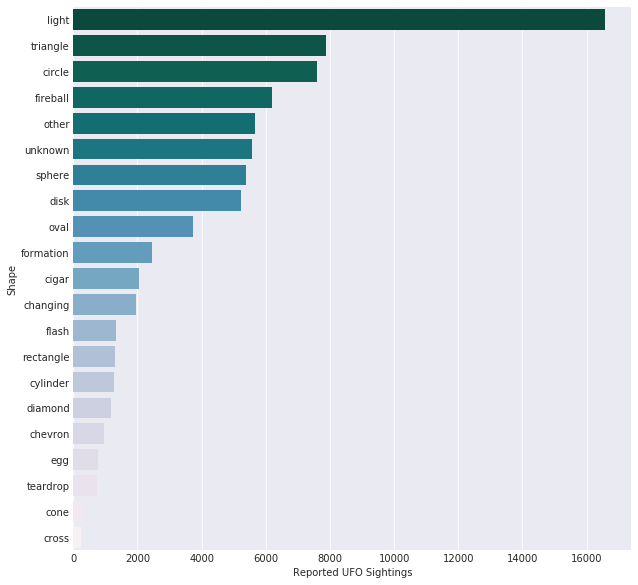

In [8]:
# generate a bar plot of ufo shapes. pandas/matplotlib version commented

#ax = shape_freq[:20].plot.bar(x='shape', y='count', figsize=(15,9))
data = ufos.select('shape').toPandas().dropna()
fig, ax = plt.subplots(figsize=(10, 10))
# order of axis labels, drop labels with few sightings
order = data['shape'].value_counts().index.drop(['delta', 'round', 'crescent', 'hexagon', 'flare', 'pyramid', 'dome', 'changed'])
ax = sns.countplot(y="shape", data=data, palette='PuBuGn_r', order=order)
ax.set(xlabel='Reported UFO Sightings', ylabel='Shape')

#### Findings
The number of triangle UFOs is surprising when you consider that "light", "circle", "fireball", "sphere", etc are all very similar and could be grouped together.

Next we'll look at how the the number of UFO sightings is distributed throughout the months of the year.

In [9]:
# get a dataframe of month counts, convert to pandas, sort by month, drop NaN entry
month_freq = count_values(ufos, month(ufos['datetime'])).toPandas()
month_freq = month_freq.sort_values('month(datetime)').dropna()
month_freq

,month(datetime),count
6,1.0,5632
11,2.0,4626
9,3.0,5407
8,4.0,5489
10,5.0,5240
2,6.0,8019
0,7.0,9441
1,8.0,8588
3,9.0,7535
4,10.0,7343


[Text(0,0.5,'Reported UFO Sightings'),
 [Text(0,0,'Jan'),
  Text(0,0,'Feb'),
  Text(0,0,'Mar'),
  Text(0,0,'Apr'),
  Text(0,0,'May'),
  Text(0,0,'Jun'),
  Text(0,0,'Jul'),
  Text(0,0,'Aug'),
  Text(0,0,'Sep'),
  Text(0,0,'Oct'),
  Text(0,0,'Nov'),
  Text(0,0,'Dec')],
 Text(0.5,0,'Month')]

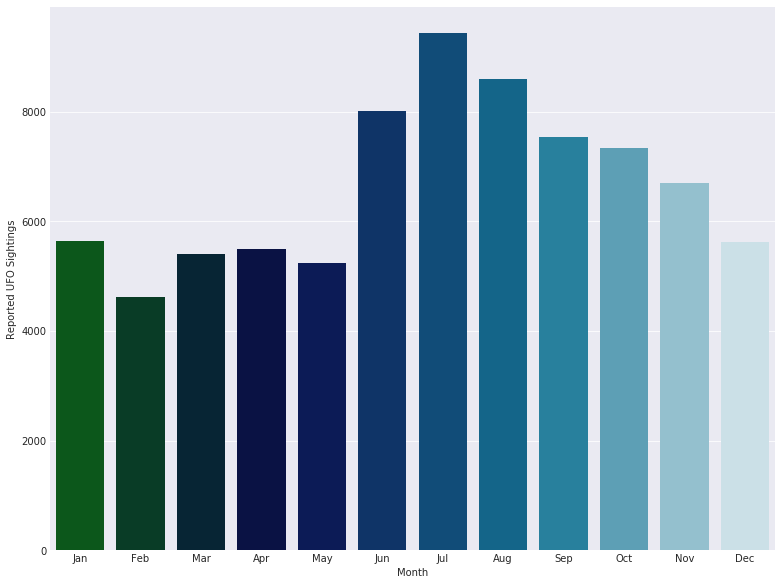

In [10]:
# generate a bar plot of ufo sightings per month

#ax = month_freq.plot.bar(x='month', y='count', figsize=(15,9))
data = ufos.select(month(ufos['datetime'])).toPandas().dropna()
fig, ax = plt.subplots(figsize=(13, 10))
ax = sns.countplot(x='month(datetime)', data=data, palette='ocean')
ax.set(xticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
       xlabel='Month',
       ylabel='Reported UFO Sightings')

#### Findings
It seems that UFO sightings are more frequent from June through November, with July being the most common month for sightings. Perhaps there are more sightings in summer months because they are a more common time for people to be outside at night. Still, it's worth noting that November and December have more sightings than April and May.

We move on to visualizing the distribution of UFO sightings according to the time of day.

In [11]:
# get a dataframe of hour counts, convert to pandas, sort by hour, drop NaN entry
hour_freq = count_values(ufos, hour(ufos['datetime'])).toPandas()
hour_freq = hour_freq.sort_values('hour(datetime)').dropna()
hour_freq.head()

,hour(datetime),count
5,0.0,4108
7,1.0,3210
9,2.0,2353
10,3.0,2004
13,4.0,1529


[Text(0,0.5,'Reported UFO Sightings'), Text(0.5,0,'Time of Day')]

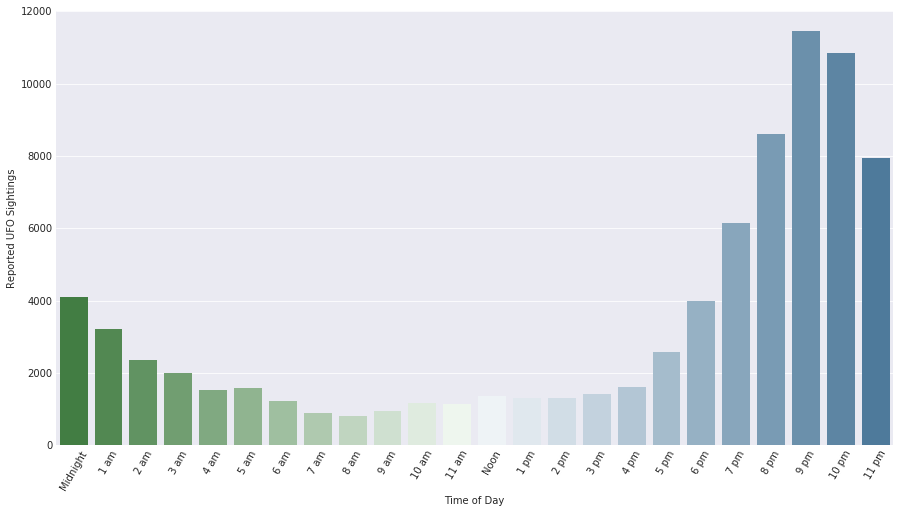

In [12]:
# generate a bar plot of ufo sightings per hour of the day

data = ufos.select(hour(ufos['datetime'])).toPandas().dropna()
fig, ax = plt.subplots(figsize=(15, 8))
ax = sns.countplot(x='hour(datetime)', data=data, palette=sns.diverging_palette(128, 240, n=24))
ax.set_xticklabels(rotation=60, labels=['Midnight', '1 am', '2 am', '3 am', '4 am', '5 am', '6 am', '7 am', '8 am', '9 am', '10 am', '11 am', 'Noon', '1 pm', '2 pm', '3 pm', '4 pm', '5 pm', '6 pm', '7 pm', '8 pm', '9 pm', '10 pm', '11 pm'])
ax.set(xlabel='Time of Day',ylabel='Reported UFO Sightings')

#### Findings

7 - 10 am is the least common time for UFO sightings. It makes sense that the majority of UFO sightings are at night, because it's easier to see lights in the night sky. I would expect there to be more 7-8 am sightings considering that people are going to work, sometimes still in the dark.

Next we'll see the number of reported UFO sightings by US states.

In [13]:
# get a dataframe US state counts, convert to pandas for convenience, sort by hour, drop NaN entry
state_freq = count_values(ufos[ufos['country'] == 'us'], 'state').toPandas()
state_freq.head(10)

,state,count
0,ca,8912
1,wa,3966
2,fl,3835
3,tx,3447
4,ny,2980
5,il,2499
6,az,2414
7,pa,2366
8,oh,2275
9,mi,1836


[Text(0,0.5,'State'), Text(0.5,0,'Reported UFO Sightings')]

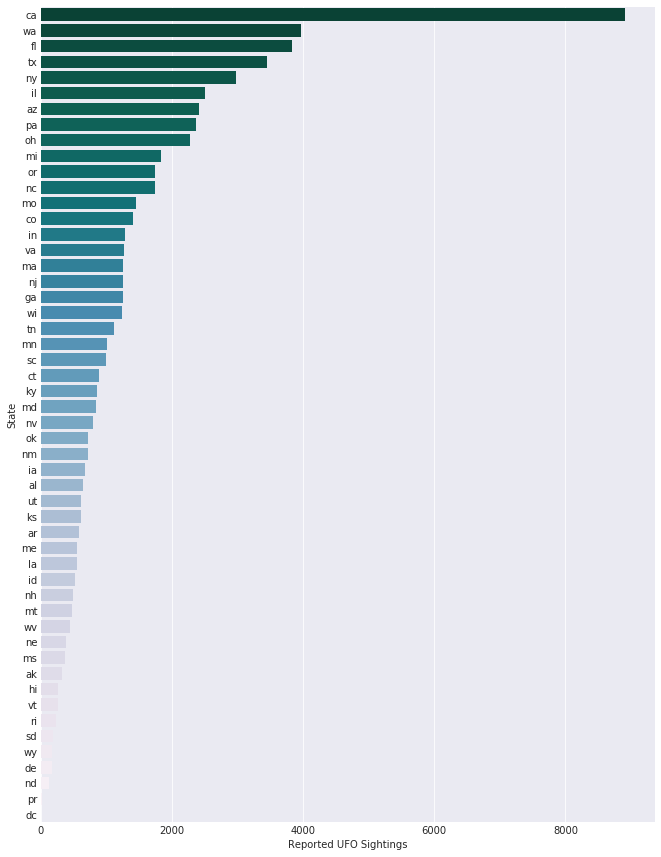

In [14]:
# generate a bar plot of ufo sightings from each state

#ax = state_freq.plot.bar(x='state', y='count', figsize=(17,9))
data = ufos[ufos['country'] == 'us'].select(ufos['state']).toPandas().dropna()
fig, ax = plt.subplots(figsize=(11, 15))
order = data['state'].value_counts().index
ax = sns.countplot(y="state", data=data, palette='PuBuGn_r', order = order)
ax.set(xlabel='Reported UFO Sightings',ylabel='State')

#### Findings

While this chart is interesting, it's obvious that the population of each state plays a large factor in how many UFO sightings are reported. We'll come back to this problem soon.

To explore the comments column, I've made a small function that searches the comments for a string. The how_many parameter adjusts the number of matches returned. The search is case sensetive. (this could be improved quite a bit)

In [15]:
def search_col_for_string(df, col, phrase, how_many=10):
    """Search spark dataframe column for a string. Display how_many results."""
    term = "%"+phrase+"%"
    print("Results found: " + str(df[df[col].like(term)].count()) + "\nShowing: " + str(how_many) +'\n\n')
    df[df[col].like(term)].show(how_many,truncate=False)

In [16]:
search_col_for_string(ufos, 'comments', phrase='purple')

Results found: 127
Showing: 10


+-------------------+--------------------+-----+-------+--------+------------------+--------------------+---------------------------------------------------------------------------------------------------------------------------------------------------+-----------+----------+------------+
|datetime           |city                |state|country|shape   |duration (seconds)|duration (hours/min)|comments                                                                                                                                           |date posted|latitude  |longitude   |
+-------------------+--------------------+-----+-------+--------+------------------+--------------------+---------------------------------------------------------------------------------------------------------------------------------------------------+-----------+----------+------------+
|1997-10-10 17:00:00|mesa                |az   |us     |sphere  |30                |30 seconds   

### Culminating data for state analysis
To get a better idea of which states are best for spotting UFOs, we should take the population of each state into consideration. My methodology was to find the year with the most United States records in the full dataset. From the data corresponding to that year (2012), I culled UFO information about each state into a new dataframe containing state population projections for that year.

In [17]:
# get a dataframe of year counts, convert to pandas, sort by month, drop NaN entry
year_freq = count_values(ufos[ufos['country'] == 'us'], year(ufos['datetime'])).toPandas()
year_freq.head()

,year(datetime),count
0,2012.0,6282
1,2013.0,6023
2,2011.0,4352
3,2008.0,3990
4,2009.0,3649


#### 2012 has the most records, so we'll use data from 2012 to do further analysis.

In [18]:
# pull United States ufo data from 2012
USA_UFOs_2012 = (ufos.withColumn("year", year(ufos['datetime'])))
USA_UFOs_2012 = (USA_UFOs_2012
                .filter( (USA_UFOs_2012['country'] == 'us') & (USA_UFOs_2012['year'] == 2012)) 
                .select('state', 'city', 'datetime', 'shape', 'duration (seconds)', 'comments')
                .toPandas())
USA_UFOs_2012.head()

,state,city,datetime,shape,duration (seconds),comments
0,ct,bridgeport,2012-10-10 10:15:00,circle,630,A Bright light that is a UFO
1,ca,san diego,2012-10-10 18:56:00,sphere,240,Single white light or craft passed over and ve...
2,mi,sterling heights,2012-10-10 19:09:00,oval,120,A black unknown craft is seen in the sky over ...
3,ny,syracuse,2012-10-10 19:40:00,light,900,Went to move my car to the other side of the r...
4,ny,syracuse,2012-10-10 19:45:00,circle,240,Bright orange circles going thru the sky in th...


In [19]:
# remove records where state is dc, ak, hi
for state in ['dc', 'ak', 'hi']:
    USA_UFOs_2012 = USA_UFOs_2012[USA_UFOs_2012['state'] != state]
#print(len(USA_UFOs_2012['state'].unique()))
np.sort(USA_UFOs_2012['state'].unique())

array(['al', 'ar', 'az', 'ca', 'co', 'ct', 'de', 'fl', 'ga', 'ia', 'id',
       'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo',
       'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh',
       'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt',
       'wa', 'wi', 'wv', 'wy'], dtype=object)

In [20]:
# get a dictionary of the city with the most sightings for each state
# take care to make sure columns line up correctly

most_sighting_city =  {}
for state in np.sort(USA_UFOs_2012['state'].unique()):
    st_data = USA_UFOs_2012[USA_UFOs_2012['state'] == state]
    most_sighting_city[state] = st_data['city'].value_counts().idxmax()
#print(most_sighting_city)

# get a dictionary of the longest duration sighting for each state
longest_sighting =  {}
for state in np.sort(USA_UFOs_2012['state'].unique()):
    st_data = USA_UFOs_2012[USA_UFOs_2012['state'] == state]
    longest_sighting[state] = st_data['duration (seconds)'].max()
    
#print(longest_sighting)

# get a dictionary with number of sightings in each state
sightings_by_state = {}
for state in np.sort(USA_UFOs_2012['state'].unique()):
    st_data = USA_UFOs_2012[USA_UFOs_2012['state'] == state]
    sightings_by_state[state] = st_data.shape[0]
    
#print(sightings_by_state)

# get a dictionary of the most common shape for each state
most_common_shape =  {}
for state in np.sort(USA_UFOs_2012['state'].unique()):
    st_data = USA_UFOs_2012[USA_UFOs_2012['state'] == state]
    most_common_shape[state] = st_data['shape'].value_counts().idxmax()
    
#print(most_common_shape)

#### Loading the population data

Now load state population projections for the year 2012. This data comes from data.gov, but the dataset has been removed. We'll use this to create a new dataframe where each row is a unique state with UFO information related to that state.

In [21]:
# read 2012 state population data
statepop = pd.read_csv('statepop.csv')
# drop all columns besides state name and 2012 estimated population
statepop = statepop[['NAME', 'POPESTIMATE2012']]
# drop non-state entries and non-contiguous states
drop_list = ['United States', 'Northeast Region', 'Midwest Region', 'South Region', 'West Region', 'District of Columbia', 'Alaska', 'Hawaii', 'Puerto Rico']
for item in drop_list:
    statepop = statepop[statepop['NAME'] != item]
# sort by NAME and reset index
statepop = statepop.sort_values('NAME').reset_index(drop=True)
statepop.head()

,NAME,POPESTIMATE2012
0,Alabama,4816089
1,Arizona,6553262
2,Arkansas,2949499
3,California,38056055
4,Colorado,5191731


#### Shaping the data

In [22]:
# a dictionary of state names and abbreviations
us_state_abbrev = {
    'Alabama': 'AL',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

# create a state column using the dictionary
statepop['state'] = [x.lower() for x in us_state_abbrev.values()]
# to ensure rows line up, sort by state and reset index
statepop = statepop.sort_values('state').reset_index(drop=True)
statepop = statepop[['state','NAME','POPESTIMATE2012']]
statepop.head()

,state,NAME,POPESTIMATE2012
0,al,Alabama,4816089
1,ar,Arkansas,2949499
2,az,Arizona,6553262
3,ca,California,38056055
4,co,Colorado,5191731


In [23]:
# add columns from dictionaries created earlier
statepop['2012 reported sightings'] = sightings_by_state.values()
statepop['sightings per 1M residents'] = (statepop['2012 reported sightings'] / statepop['POPESTIMATE2012']) * 1000000
statepop['most sighting city'] = most_sighting_city.values()
statepop['common UFO shape'] = most_common_shape.values()
statepop['longest sighting (seconds)'] = longest_sighting.values()
# color index for the visualization
statepop['color index'] = (statepop['sightings per 1M residents'] / 8).astype(int)

### UFO data by states
Here is the new data we processed from the larger dataframe. We can see that the top per capita UFO sighting states are Vermont, Montana, Maine, New Hampshire, and Washington.

In [24]:
# sort by most sightings per capita
statepop.sort_values('sightings per 1M residents', ascending=False)

,state,NAME,POPESTIMATE2012,2012 reported sightings,sightings per 1M residents,most sighting city,common UFO shape,longest sighting (seconds),color index
43,vt,Vermont,626398,50,79.821455,williston,fireball,10800,9
23,mt,Montana,1005157,67,66.656254,bozeman,light,10800,8
18,me,Maine,1328888,84,63.210745,bangor,light,10800,7
27,nh,New Hampshire,1321393,71,53.731176,nashua,light,14400,6
44,wa,Washington,6897292,366,53.064304,seattle,light,52623200,6
34,or,Oregon,3899444,154,39.492810,portland,light,16200,4
5,ct,Connecticut,3593541,138,38.402233,milford,light,10800,4
37,sc,South Carolina,4721341,163,34.524090,myrtle beach,light,18000,4
36,ri,Rhode Island,1052393,35,33.257538,cranston,circle,7200,4
10,id,Idaho,1596097,50,31.326417,boise,light,7200,3


In [25]:
# delete from the map coordinate data imported above
del states["DC"]
del states["HI"]
del states["AK"]

In [26]:
# create state longitude and latitude dictionaries from the bokeh data 
lons_dict = {}
for code in  np.sort(list(us_state_abbrev.values())):
    lons_dict[code] = states[code]['lons']
#print(lons_dict)

lats_dict = {}
for code in  np.sort(list(us_state_abbrev.values())):
    lats_dict[code] = states[code]['lats']
#print(lons_dict)

# store the coordinates in the dataframe
statepop['lons'] = lons_dict.values()
statepop['lats'] = lats_dict.values()

In [27]:
# create a color set
colors = ['#ffffd9',
 '#edf8b1',
 '#c7e9b4',
 '#7fcdbb',
 '#41b6c4',
 '#1d91c0',
 '#225ea8',
 '#253494',
 '#081d58']

# map each state's per capita UFO sightings to a color
state_colors = []
for index in statepop['color index'].tolist():
    state_colors.append(colors[index - 1])
#state_colors

Loading BokehJS ...

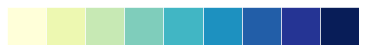

In [28]:
# create the map with bokeh
output_notebook()
p = figure(title="UFO sightings per capita", toolbar_location="above",
           plot_width=1000, plot_height=600)

p.patches(statepop['lons'].tolist(), statepop['lats'].tolist(),
          fill_color=state_colors, fill_alpha=0.7,
          line_color="#000000", line_width=2, line_alpha=0.5)


show(p)

# plot the palette
sns.palplot(colors, size=.7)

<img src='bokeh_plot.png'>